In [1]:
import sympy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from functions_and_derivatives import a_grav, da_grav_dp_vec, d2a_grav_dp_vec_dp_vecT, a_J2, da_J2_dp_vec, d2a_J2_dp_vec_dp_vecT, a_drag, da_drag_dp_vec, da_drag_dv_vec, d2a_drag_dp_vec_dp_vecT, d2a_drag_dv_vec_dp_vecT, d2a_drag_dp_vec_dv_vecT, d2a_drag_dv_vec_dv_vecT

### Derivatives for the differential equation (acceleration due to gravity) wrt the position vector

In [109]:
N = 4
n_x = 6
n_p = 3
mu = 1.0
J_2 = 1.0
R = 1.0
C_drag = 1.0
A_drag = 1.0
m = 1.0
rho_0 = 1.0
h_0 = 1.0
H = 1.0
omega = 1.0

def function(p_vec):
    x_vec = np.concatenate((p_vec, np.ones((3, 1))))
    return a_grav(p_vec) + a_J2(p_vec) + a_drag(x_vec)

def first_order_partial_derivatives(p_vec):
    x_vec = np.concatenate((p_vec, np.ones((3, 1))))
    return da_grav_dp_vec(p_vec) + da_J2_dp_vec(p_vec) + da_drag_dp_vec(x_vec)

def second_order_partial_derivatives(p_vec):
    x_vec = np.concatenate((p_vec, np.ones((3, 1))))
    return d2a_grav_dp_vec_dp_vecT(p_vec) + d2a_J2_dp_vec_dp_vecT(p_vec) + d2a_drag_dp_vec_dp_vecT(x_vec)

In [111]:
p1, p2, p3 = sp.symbols('p1 p2 p3')
p_vec = sp.Matrix([p1, p2, p3])
v_vec = sp.Matrix([1.0, 1.0, 1.0])
p_norm = sp.sqrt(p1**2 + p2**2 + p3**2)
h = p_norm - R
rho = rho_0 * sp.exp(-(h - h_0) / H)
omega_vec = sp.Matrix([0, 0, omega])
v_vec_rel = v_vec - omega_vec.cross(p_vec)
v_rel_norm = sp.sqrt(v_vec_rel[0]**2 + v_vec_rel[1]**2 + v_vec_rel[2]**2)
fun = -mu * p_vec / p_norm**3 -3 * J_2 * mu * R**2 / (2 * p_norm**5) * sp.Matrix([[(1 - 5 * p3**2 / p_norm**2) * p1], [(1 - 5 * p3**2 / p_norm**2) * p2], [(3 - 5 * p3**2 / p_norm**2) * p3]]) - 1 / 2 * C_drag * A_drag / m * rho * v_rel_norm * v_vec_rel
first_order_der = fun.jacobian(p_vec)
first_order_der_fun = sp.lambdify(p_vec, first_order_der.tolist(), 'numpy')
second_order_der = sp.MutableDenseNDimArray([[[first_order_der[i, j].diff(p_vec[k]) for k in range(3)] for j in range(3)] for i in range(3)])
second_order_der_fun = sp.lambdify(p_vec, second_order_der.tolist(), 'numpy')

# Example point
std = 1e0
sample_p_vec = np.random.multivariate_normal(mean=np.zeros(3,), cov=std*np.eye(3)).reshape((3, 1))

# First Order Partial Derivatives Comparison
first_order_partial_derivatives_symbolic = np.array(first_order_der_fun(*sample_p_vec)).reshape((3, 3))
first_order_partial_derivatives_analytical = first_order_partial_derivatives(sample_p_vec)
print(np.allclose(first_order_partial_derivatives_analytical, first_order_partial_derivatives_symbolic, atol=1e-6))

# Second Order Partial Derivatives Comparison
second_order_partial_derivatives_symbolic = np.array(second_order_der_fun(*sample_p_vec.flatten())).reshape((3 * 3, 3))
second_order_partial_derivatives_analytical = second_order_partial_derivatives(sample_p_vec)
print(np.allclose(second_order_partial_derivatives_analytical, second_order_partial_derivatives_symbolic, atol=1e-6))

M = 100
all_close_results = []
for _ in range(M):
    sample_p_vec = np.random.multivariate_normal(mean=np.zeros(3,), cov=std*np.eye(3)).reshape((3, 1))
    first_order_partial_derivatives_symbolic = np.array(first_order_der_fun(*sample_p_vec)).reshape((3, 3))
    first_order_partial_derivatives_analytical = first_order_partial_derivatives(sample_p_vec)
    second_order_partial_derivatives_symbolic = np.array(second_order_der_fun(*sample_p_vec.flatten())).reshape((3 * 3, 3))
    second_order_partial_derivatives_analytical = second_order_partial_derivatives(sample_p_vec)
    all_close = np.allclose(first_order_partial_derivatives_analytical, first_order_partial_derivatives_symbolic, atol=1e-6) and np.allclose(second_order_partial_derivatives_analytical, second_order_partial_derivatives_symbolic, atol=1e-6)
    all_close_results.append(all_close)
print(f"All Cases Passed?: {all(all_close_results)}")

True
True
All Cases Passed?: True


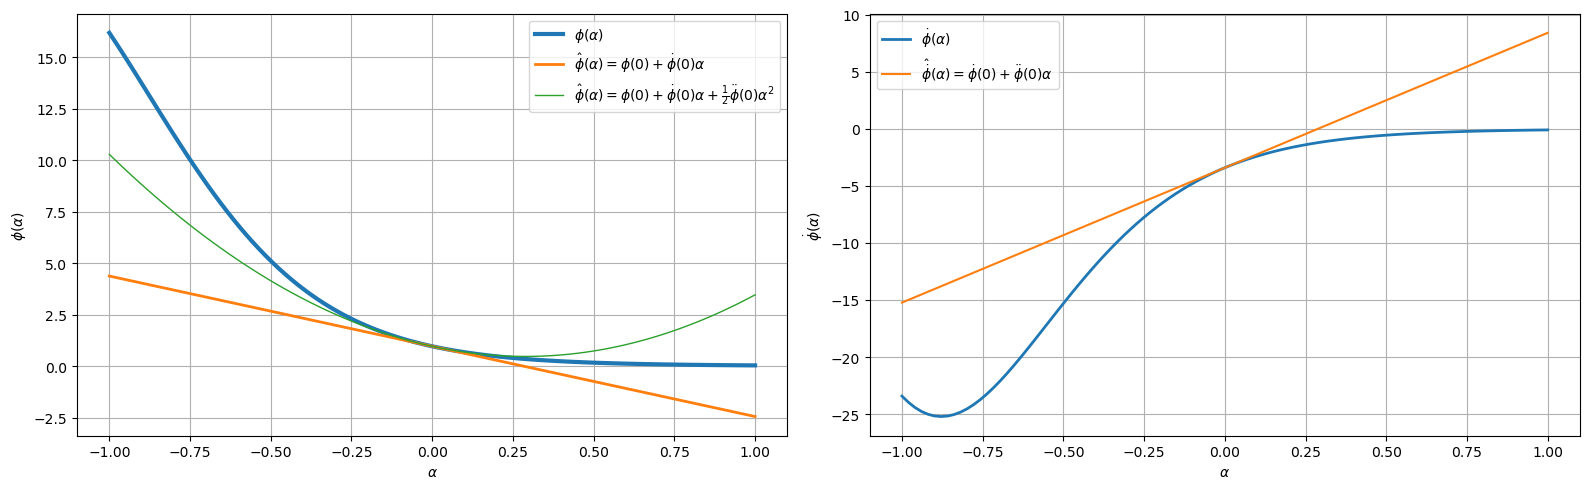

In [47]:
def test_function(p, alpha, p_vec):
    cost = function(p + alpha * p_vec)
    return 1 / 2 * np.linalg.norm(cost)**2

def test_function_grad(p, alpha, p_vec):
    cost = function(p + alpha * p_vec)
    jacobian = first_order_partial_derivatives(p + alpha * p_vec)
    return cost.T @ jacobian @ p_vec

def test_function_hessian(p, alpha, p_vec):
    n = len(p_vec)
    cost = function(p + alpha * p_vec)
    jacobian = first_order_partial_derivatives(p + alpha * p_vec)
    hessian = second_order_partial_derivatives(p + alpha * p_vec)
    return cost.T @ np.kron(np.eye(n), p_vec).T @ hessian @ p_vec + p_vec.T @ jacobian.T @ jacobian @ p_vec

def test_function_approx_first_order(p, alpha, x_vec):
    return test_function(p, 0, x_vec) + test_function_grad(p, 0, x_vec) * alpha

def test_function_approx_second_order(p, alpha, x_vec):
    return test_function(p, 0, x_vec) + test_function_grad(p, 0, x_vec) * alpha + 1/2 * test_function_hessian(p, 0, x_vec) * alpha**2

def test_function_grad_approx_first_order(p, alpha, x_vec):
    return test_function_grad(p, 0, x_vec) + test_function_hessian(p, 0, x_vec) * alpha

std = 1e0
sample_p_vec = np.random.multivariate_normal(mean=np.zeros(3,), cov=std*np.eye(3)).reshape((3, 1))
p = np.random.multivariate_normal(mean=np.zeros(3,), cov=std*np.eye(3)).reshape((3, 1))

aux = 1e0
alpha_bounds = np.linspace(-aux, aux, 100)
cost_values = np.array([test_function(p, alpha, sample_p_vec).flatten() for alpha in alpha_bounds])
gradient_values = np.array([test_function_grad(p, alpha, sample_p_vec).flatten() for alpha in alpha_bounds])
hessian_values = np.array([test_function_hessian(p, alpha, sample_p_vec).flatten() for alpha in alpha_bounds])
taylor_series_first_order_expansion_test_function = np.array([test_function_approx_first_order(p, alpha, sample_p_vec).flatten() for alpha in alpha_bounds])
taylor_series_second_order_expansion_test_function = np.array([test_function_approx_second_order(p, alpha, sample_p_vec).flatten() for alpha in alpha_bounds])
taylor_series_first_order_expansion_test_function_grad = np.array([test_function_grad_approx_first_order(p, alpha, sample_p_vec).flatten() for alpha in alpha_bounds])

# Arrows arrows
num_arrows = 30
arrow_indices = np.linspace(0, len(alpha_bounds) - 1, num_arrows, dtype=int)

def compute_tangent_slope(x, y, idx):
    """Compute the slope of the tangent line at a given index idx."""
    if idx == 0:
        slope = (y[idx + 1] - y[idx]) / (x[idx + 1] - x[idx])
    elif idx == len(x) - 1:
        slope = (y[idx] - y[idx - 1]) / (x[idx] - x[idx - 1])
    else:
        slope = (y[idx + 1] - y[idx - 1]) / (x[idx + 1] - x[idx - 1])

    return slope

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Left plot: Function and gradient arrows
axes[0].plot(alpha_bounds, cost_values, label=r'$\phi(\alpha)$', linewidth=3)
# axes[0].quiver(alpha_bounds[arrow_indices], cost_values[arrow_indices], 
#                np.ones_like(arrow_indices), gradient_values[arrow_indices], 
#                angles='xy', scale_units='xy', color='red', width=0.004, zorder=2, label=r'Analytical $\dot{\phi}(\alpha)$')
# axes[0].quiver(alpha_bounds[arrow_indices][1:], cost_values[arrow_indices][1:],
#                 np.ones_like(arrow_indices[1:]), np.array([compute_tangent_slope(alpha_bounds, cost_values, idx) for idx in arrow_indices])[1:],
#                 angles="xy", scale_units="xy", color="black", width=0.005, label=r'Numerical $\dot{\phi}(\alpha)$')
axes[0].plot(alpha_bounds, taylor_series_first_order_expansion_test_function, label=r'$\hat{\phi}(\alpha) = \phi(0) + \dot{\phi}(0)\alpha$', zorder=3, linewidth=2)
axes[0].plot(alpha_bounds, taylor_series_second_order_expansion_test_function, label=r'$\hat{\phi}(\alpha) = \phi(0) + \dot{\phi}(0)\alpha + \frac{1}{2}\ddot{\phi}(0)\alpha^2$', zorder=3, linewidth=1)
axes[0].set_xlabel(r'$\alpha$')
axes[0].set_ylabel(r'$\phi(\alpha)$')
axes[0].grid()
axes[0].legend()

# Right plot: Gradient and Hessian arrows
axes[1].plot(alpha_bounds, gradient_values, label=r'$\dot{\phi}(\alpha)$', linewidth=2)
# axes[1].quiver(alpha_bounds[arrow_indices], gradient_values[arrow_indices], 
#                np.ones_like(arrow_indices), hessian_values[arrow_indices], 
#                angles='xy', scale_units='xy', color='red', width=0.004, zorder=2, label=r'Analytical $\ddot{\phi}(\alpha)$')
# axes[1].quiver(alpha_bounds[arrow_indices][1:], gradient_values[arrow_indices][1:], 
#                np.ones_like(arrow_indices[1:]), np.array([compute_tangent_slope(alpha_bounds, gradient_values, idx) for idx in arrow_indices])[1:], 
#                angles="xy", scale_units="xy", color="black", width=0.005, label=r'Numerical $\ddot{\phi}(\alpha)$')
axes[1].plot(alpha_bounds, taylor_series_first_order_expansion_test_function_grad, label=r'$\hat{\dot{\phi}}(\alpha) = \dot{\phi}(0) + \ddot{\phi}(0)\alpha$', zorder=3)
axes[1].set_xlabel(r'$\alpha$')
axes[1].set_ylabel(r'$\dot{\phi}(\alpha)$')
axes[1].grid()
axes[1].legend()

plt.tight_layout()
plt.show()

### Derivatives for the differential equation (acceleration due to gravity) wrt the state vector for one agent

In [112]:
def differential_equation(x_vec):
    p_vec = x_vec[:3]
    v_vec = x_vec[3:]
    return np.concatenate((v_vec, a_grav(p_vec) + a_J2(p_vec) + a_drag(x_vec)))

def first_order_partial_derivatives_for_the_differential_equation(x_vec):
    first_order_pder = np.zeros((6, 6))
    p_vec = x_vec[:3]
    first_order_pder[:3, 3:] = np.eye(3)
    first_order_pder[3:, :3] = da_grav_dp_vec(p_vec) + da_J2_dp_vec(p_vec) + da_drag_dp_vec(x_vec)
    first_order_pder[3:, 3:] = da_drag_dv_vec(x_vec)
    return first_order_pder

def second_order_partial_derivatives_for_the_differential_equation(x_vec):
    n = len(x_vec)
    second_order_pder = np.zeros((n, n, n))
    p_vec = x_vec[:3]
    aux_pp = (d2a_grav_dp_vec_dp_vecT(p_vec) + d2a_J2_dp_vec_dp_vecT(p_vec) + d2a_drag_dp_vec_dp_vecT(x_vec)).reshape((n_p, n_p, n_p))
    aux_pv = d2a_drag_dp_vec_dv_vecT(x_vec).reshape((n_p, n_p, n_p))
    aux_vp = d2a_drag_dv_vec_dp_vecT(x_vec).reshape((n_p, n_p, n_p))
    aux_vv = d2a_drag_dv_vec_dv_vecT(x_vec).reshape((n_p, n_p, n_p))
    for i in range(3):
        second_order_pder[3:, :3, i] += aux_pp[:, :, i]
        second_order_pder[3:, :3, i + 3] += aux_pv[:, :, i]
        second_order_pder[3:, 3:, i] += aux_vp[:, :, i]
        second_order_pder[3:, 3:, i + 3] += aux_vv[:, :, i]
    return second_order_pder

In [114]:
# Symbolic
p1, p2, p3, v1, v2, v3 = sp.symbols('p1 p2 p3 v1 v2 v3')
p_vec = sp.Matrix([p1, p2, p3])
v_vec = sp.Matrix([v1, v2, v3])
x_vec = sp.Matrix([p1, p2, p3, v1, v2, v3])
p_norm = sp.sqrt(p1**2 + p2**2 + p3**2)
h = p_norm - R
rho = rho_0 * sp.exp(-(h - h_0) / H)
omega_vec = sp.Matrix([0, 0, omega])
v_vec_rel = v_vec - omega_vec.cross(p_vec)
v_rel_norm = sp.sqrt(v_vec_rel[0]**2 + v_vec_rel[1]**2 + v_vec_rel[2]**2)
fun = sp.Matrix.vstack(v_vec, -mu * p_vec / p_norm**3 -3 * J_2 * mu * R**2 / (2 * p_norm**5) * sp.Matrix([[(1 - 5 * p3**2 / p_norm**2) * p1], [(1 - 5 * p3**2 / p_norm**2) * p2], [(3 - 5 * p3**2 / p_norm**2) * p3]]) - 1 / 2 * C_drag * A_drag / m * rho * v_rel_norm * v_vec_rel)
first_order_der = fun.jacobian(x_vec)
first_order_der_fun = sp.lambdify(x_vec, first_order_der.tolist(), 'numpy')
second_order_der = sp.MutableDenseNDimArray([[[first_order_der[i, j].diff(x_vec[k]) for k in range(6)] for j in range(6)] for i in range(6)])
second_order_der_fun = sp.lambdify(x_vec, second_order_der.tolist(), 'numpy')

# Example point
std = 1e0
sample_x_vec = np.random.multivariate_normal(mean=np.zeros(6,), cov=std*np.eye(6)).reshape((6, 1))

# First Order Partial Derivatives Comparison
first_order_partial_derivatives_symbolic = np.array(first_order_der_fun(*sample_x_vec.flatten())).reshape((6, 6))
first_order_partial_derivatives_analytical = first_order_partial_derivatives_for_the_differential_equation(sample_x_vec)
print(np.allclose(first_order_partial_derivatives_analytical, first_order_partial_derivatives_symbolic, atol=1e-6))

# Second Order Partial Derivatives Comparison
second_order_partial_derivatives_symbolic = np.array(second_order_der_fun(*sample_x_vec.flatten())).reshape((6, 6, 6))
second_order_partial_derivatives_analytical = second_order_partial_derivatives_for_the_differential_equation(sample_x_vec)
print(np.allclose(second_order_partial_derivatives_analytical, second_order_partial_derivatives_symbolic, atol=1e-6))

M = 100
all_close_results = []
for _ in range(M):
    sample_x_vec = np.random.multivariate_normal(mean=np.zeros(6,), cov=std*np.eye(6)).reshape((6, 1))
    first_order_partial_derivatives_symbolic = np.array(first_order_der_fun(*sample_x_vec.flatten())).reshape((6, 6))
    first_order_partial_derivatives_analytical = first_order_partial_derivatives_for_the_differential_equation(sample_x_vec)
    second_order_partial_derivatives_symbolic = np.array(second_order_der_fun(*sample_x_vec.flatten())).reshape((6, 6, 6))
    second_order_partial_derivatives_analytical = second_order_partial_derivatives_for_the_differential_equation(sample_x_vec)
    all_close = np.allclose(first_order_partial_derivatives_analytical, first_order_partial_derivatives_symbolic, atol=1e-6) and np.allclose(second_order_partial_derivatives_analytical, second_order_partial_derivatives_symbolic, atol=1e-6)
    all_close_results.append(all_close)
print(f"All Cases Passed?: {all(all_close_results)}")

True
True
All Cases Passed?: True


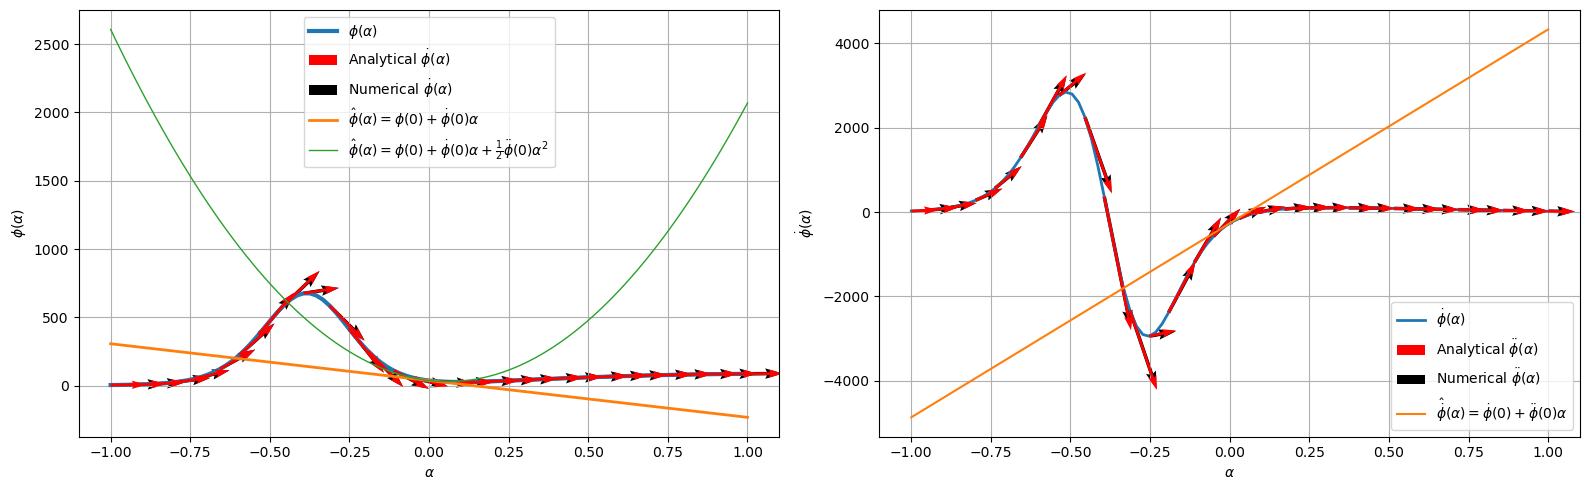

In [103]:
def test_function(p, alpha, x_vec):
    cost = differential_equation(p + alpha * x_vec)
    return 1 / 2 * np.linalg.norm(cost)**2

def test_function_grad(p, alpha, x_vec):
    cost = differential_equation(p + alpha * x_vec)
    jacobian = first_order_partial_derivatives_for_the_differential_equation(p + alpha * x_vec)
    return cost.T @ jacobian @ x_vec

def test_function_hessian(p, alpha, x_vec):
    n = len(x_vec)
    cost = differential_equation(p + alpha * x_vec)
    jacobian = first_order_partial_derivatives_for_the_differential_equation(p + alpha * x_vec)
    hessian = second_order_partial_derivatives_for_the_differential_equation(p + alpha * x_vec).reshape((n * n, n))
    return cost.T @ np.kron(np.eye(n), x_vec).T @ hessian @ x_vec + x_vec.T @ jacobian.T @ jacobian @ x_vec

def test_function_approx_first_order(p, alpha, x_vec):
    return test_function(p, 0, x_vec) + test_function_grad(p, 0, x_vec) * alpha

def test_function_approx_second_order(p, alpha, x_vec):
    return test_function(p, 0, x_vec) + test_function_grad(p, 0, x_vec) * alpha + 1/2 * test_function_hessian(p, 0, x_vec) * alpha**2

def test_function_grad_approx_first_order(p, alpha, x_vec):
    return test_function_grad(p, 0, x_vec) + test_function_hessian(p, 0, x_vec) * alpha

std = 1e0
sample_x_vec = np.random.multivariate_normal(mean=np.zeros(6,), cov=std*np.eye(6)).reshape((6, 1))
p = np.random.multivariate_normal(mean=np.zeros(6,), cov=std*np.eye(6)).reshape((6, 1))

aux = 1e0
alpha_bounds = np.linspace(-aux, aux, 100)
cost_values = np.array([test_function(p, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
gradient_values = np.array([test_function_grad(p, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
hessian_values = np.array([test_function_hessian(p, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
taylor_series_first_order_expansion_test_function = np.array([test_function_approx_first_order(p, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
taylor_series_second_order_expansion_test_function = np.array([test_function_approx_second_order(p, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
taylor_series_first_order_expansion_test_function_grad = np.array([test_function_grad_approx_first_order(p, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])

# Arrows arrows
num_arrows = 30
arrow_indices = np.linspace(0, len(alpha_bounds) - 1, num_arrows, dtype=int)

def compute_tangent_slope(x, y, idx):
    """Compute the slope of the tangent line at a given index idx."""
    if idx == 0:
        slope = (y[idx + 1] - y[idx]) / (x[idx + 1] - x[idx])
    elif idx == len(x) - 1:
        slope = (y[idx] - y[idx - 1]) / (x[idx] - x[idx - 1])
    else:
        slope = (y[idx + 1] - y[idx - 1]) / (x[idx + 1] - x[idx - 1])

    return slope

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Left plot: Function and gradient arrows
axes[0].plot(alpha_bounds, cost_values, label=r'$\phi(\alpha)$', linewidth=3)
axes[0].quiver(alpha_bounds[arrow_indices], cost_values[arrow_indices], 
               np.ones_like(arrow_indices), gradient_values[arrow_indices], 
               angles='xy', scale_units='xy', color='red', width=0.004, zorder=2, label=r'Analytical $\dot{\phi}(\alpha)$')
axes[0].quiver(alpha_bounds[arrow_indices][1:], cost_values[arrow_indices][1:],
                np.ones_like(arrow_indices[1:]), np.array([compute_tangent_slope(alpha_bounds, cost_values, idx) for idx in arrow_indices])[1:],
                angles="xy", scale_units="xy", color="black", width=0.005, label=r'Numerical $\dot{\phi}(\alpha)$')
axes[0].plot(alpha_bounds, taylor_series_first_order_expansion_test_function, label=r'$\hat{\phi}(\alpha) = \phi(0) + \dot{\phi}(0)\alpha$', zorder=3, linewidth=2)
axes[0].plot(alpha_bounds, taylor_series_second_order_expansion_test_function, label=r'$\hat{\phi}(\alpha) = \phi(0) + \dot{\phi}(0)\alpha + \frac{1}{2}\ddot{\phi}(0)\alpha^2$', zorder=3, linewidth=1)
axes[0].set_xlabel(r'$\alpha$')
axes[0].set_ylabel(r'$\phi(\alpha)$')
axes[0].grid()
axes[0].legend()

# Right plot: Gradient and Hessian arrows
axes[1].plot(alpha_bounds, gradient_values, label=r'$\dot{\phi}(\alpha)$', linewidth=2)
axes[1].quiver(alpha_bounds[arrow_indices], gradient_values[arrow_indices], 
               np.ones_like(arrow_indices), hessian_values[arrow_indices], 
               angles='xy', scale_units='xy', color='red', width=0.004, zorder=2, label=r'Analytical $\ddot{\phi}(\alpha)$')
axes[1].quiver(alpha_bounds[arrow_indices][1:], gradient_values[arrow_indices][1:], 
               np.ones_like(arrow_indices[1:]), np.array([compute_tangent_slope(alpha_bounds, gradient_values, idx) for idx in arrow_indices])[1:], 
               angles="xy", scale_units="xy", color="black", width=0.005, label=r'Numerical $\ddot{\phi}(\alpha)$')
axes[1].plot(alpha_bounds, taylor_series_first_order_expansion_test_function_grad, label=r'$\hat{\dot{\phi}}(\alpha) = \dot{\phi}(0) + \ddot{\phi}(0)\alpha$', zorder=3)
axes[1].set_xlabel(r'$\alpha$')
axes[1].set_ylabel(r'$\dot{\phi}(\alpha)$')
axes[1].grid()
axes[1].legend()

plt.tight_layout()
plt.show()

### Derivatives for the differential equation (acceleration due to gravity) wrt the total state vector

In [105]:
def total_differential_equation(x_vec):
    x_dot_vec = np.zeros_like(x_vec)
    for i in range(x_vec.shape[0] // 6):
        x_vec_i = x_vec[i * 6 : i * 6 + 6]
        p_vec_i = x_vec_i[:3] 
        v_vec_i = x_vec_i[3:]
        x_dot_vec[i * 6 : i * 6 + 6] = np.concatenate((v_vec_i, a_grav(p_vec_i) + a_J2(p_vec_i) + a_drag(x_vec_i)))
    return x_dot_vec

def total_first_order_partial_derivatives_for_the_differential_equation(x_vec):
    first_order_der = np.zeros((x_vec.shape[0], x_vec.shape[0]))
    
    for i in range(x_vec.shape[0] // 6):
        x_vec_i = x_vec[i * 6 : i * 6 + 6]
        p_vec_i = x_vec_i[:3] 
        first_order_der[i * 6 : i * 6 + 3, i * 6 + 3 : i * 6 + 6] = np.eye(3)
        first_order_der[i * 6 + 3 : i * 6 + 6, i * 6 : i * 6 + 3] = da_grav_dp_vec(p_vec_i) + da_J2_dp_vec(p_vec_i) + da_drag_dp_vec(x_vec_i)
        first_order_der[i * 6 + 3 : i * 6 + 6, i * 6 + 3 : i * 6 + 6] = da_drag_dv_vec(x_vec_i)
    return first_order_der

def total_second_order_partial_derivatives_for_the_differential_equation(x_vec):
    n = len(x_vec)
    second_order_der = np.zeros((n, n, n))

    for i in range(n // 6):
        x_vec_i = x_vec[i * 6 : i * 6 + 6]
        p_vec_i = x_vec_i[:3]
        aux_pp = (d2a_grav_dp_vec_dp_vecT(p_vec_i) + d2a_J2_dp_vec_dp_vecT(p_vec_i) + d2a_drag_dp_vec_dp_vecT(x_vec_i)).reshape((n_p, n_p, n_p))
        aux_pv = d2a_drag_dp_vec_dv_vecT(x_vec_i).reshape((n_p, n_p, n_p))
        aux_vp = d2a_drag_dv_vec_dp_vecT(x_vec_i).reshape((n_p, n_p, n_p))
        aux_vv = d2a_drag_dv_vec_dv_vecT(x_vec_i).reshape((n_p, n_p, n_p))

        for j in range(3): 
            second_order_der[i * 6 + 3 : i * 6 + 6, i * 6 : i * 6 + 3, i * 6 + j] = aux_pp[:, :, j]
            second_order_der[i * 6 + 3 : i * 6 + 6, i * 6 : i * 6 + 3, i * 6 + j + 3] = aux_pv[:, :, j]   
            second_order_der[i * 6 + 3 : i * 6 + 6, i * 6 + 3 : i * 6 + 6, i * 6 + j] = aux_vp[:, :, j]
            second_order_der[i * 6 + 3 : i * 6 + 6, i * 6 + 3 : i * 6 + 6, i * 6 + j + 3] = aux_vv[:, :, j]
    return second_order_der

In [106]:
# Symbolic
omega_vec = sp.Matrix([0, 0, omega])
p11, p12, p13, v11, v12, v13, p21, p22, p23, v21, v22, v23, p31, p32, p33, v31, v32, v33, p41, p42, p43, v41, v42, v43 = sp.symbols('p11 p12 p13 v11 v12 v13 p21 p22 p23 v21 v22 v23 p31 p32 p33 v31 v32 v33 p41 p42 p43 v41 v42 v43')

p_vec_1 = sp.Matrix([p11, p12, p13])
p_norm_1 = sp.sqrt(p11**2 + p12**2 + p13**2)
v_vec_1 = sp.Matrix([v11, v12, v13])
x_vec_1 = sp.Matrix([p11, p12, p13, v11, v12, v13])
h_1 = p_norm_1 - R
rho_1 = rho_0 * sp.exp(-(h_1 - h_0) / H)
v_vec_rel_1 = v_vec_1 - omega_vec.cross(p_vec_1)
v_rel_norm_1 = sp.sqrt(v_vec_rel_1[0]**2 + v_vec_rel_1[1]**2 + v_vec_rel_1[2]**2)
fun_1 = sp.Matrix.vstack(v_vec_1, -mu * p_vec_1 / p_norm_1**3 -3 * J_2 * mu * R**2 / (2 * p_norm_1**5) * sp.Matrix([[(1 - 5 * p13**2 / p_norm_1**2) * p11], [(1 - 5 * p13**2 / p_norm_1**2) * p12], [(3 - 5 * p13**2 / p_norm_1**2) * p13]]) - 1 / 2 * C_drag * A_drag / m * rho_1 * v_rel_norm_1 * v_vec_rel_1)

p_vec_2 = sp.Matrix([p21, p22, p23])
p_norm_2 = sp.sqrt(p21**2 + p22**2 + p23**2)
v_vec_2 = sp.Matrix([v21, v22, v23])
x_vec_2 = sp.Matrix([p21, p22, p23, v21, v22, v23])
h_2 = p_norm_2 - R
rho_2 = rho_0 * sp.exp(-(h_2 - h_0) / H)
v_vec_rel_2 = v_vec_2 - omega_vec.cross(p_vec_2)
v_rel_norm_2 = sp.sqrt(v_vec_rel_2[0]**2 + v_vec_rel_2[1]**2 + v_vec_rel_2[2]**2)
fun_2 = sp.Matrix.vstack(v_vec_2, -mu * p_vec_2 / p_norm_2**3 -3 * J_2 * mu * R**2 / (2 * p_norm_2**5) * sp.Matrix([[(1 - 5 * p23**2 / p_norm_2**2) * p21], [(1 - 5 * p23**2 / p_norm_2**2) * p22], [(3 - 5 * p23**2 / p_norm_2**2) * p23]]) - 1 / 2 * C_drag * A_drag / m * rho_2 * v_rel_norm_2 * v_vec_rel_2)

p_vec_3 = sp.Matrix([p31, p32, p33])
p_norm_3 = sp.sqrt(p31**2 + p32**2 + p33**2)
v_vec_3 = sp.Matrix([v31, v32, v33])
x_vec_3 = sp.Matrix([p31, p32, p33, v31, v32, v33])
h_3 = p_norm_3 - R
rho_3 = rho_0 * sp.exp(-(h_3 - h_0) / H)
v_vec_rel_3 = v_vec_3 - omega_vec.cross(p_vec_3)
v_rel_norm_3 = sp.sqrt(v_vec_rel_3[0]**2 + v_vec_rel_3[1]**2 + v_vec_rel_3[2]**2)
fun_3 = sp.Matrix.vstack(v_vec_3, -mu * p_vec_3 / p_norm_3**3 -3 * J_2 * mu * R**2 / (2 * p_norm_3**5) * sp.Matrix([[(1 - 5 * p33**2 / p_norm_3**2) * p31], [(1 - 5 * p33**2 / p_norm_3**2) * p32], [(3 - 5 * p33**2 / p_norm_3**2) * p33]]) - 1 / 2 * C_drag * A_drag / m * rho_3 * v_rel_norm_3 * v_vec_rel_3)

p_vec_4 = sp.Matrix([p41, p42, p43])
p_norm_4 = sp.sqrt(p41**2 + p42**2 + p43**2)
v_vec_4 = sp.Matrix([v41, v42, v43])
x_vec_4 = sp.Matrix([p41, p42, p43, v41, v42, v43])
h_4 = p_norm_4 - R
rho_4 = rho_0 * sp.exp(-(h_4 - h_0) / H)
v_vec_rel_4 = v_vec_4 - omega_vec.cross(p_vec_4)
v_rel_norm_4 = sp.sqrt(v_vec_rel_4[0]**2 + v_vec_rel_4[1]**2 + v_vec_rel_4[2]**2)
fun_4 = sp.Matrix.vstack(v_vec_4, -mu * p_vec_4 / p_norm_4**3 -3 * J_2 * mu * R**2 / (2 * p_norm_4**5) * sp.Matrix([[(1 - 5 * p43**2 / p_norm_4**2) * p41], [(1 - 5 * p43**2 / p_norm_4**2) * p42], [(3 - 5 * p43**2 / p_norm_4**2) * p43]]) - 1 / 2 * C_drag * A_drag / m * rho_4 * v_rel_norm_4 * v_vec_rel_4)

x_vec = sp.Matrix([x_vec_1, x_vec_2, x_vec_3, x_vec_4])
fun = sp.Matrix.vstack(fun_1, fun_2, fun_3, fun_4)

first_order_der = fun.jacobian(x_vec)
first_order_der_fun = sp.lambdify(x_vec, sp.ImmutableDenseNDimArray(first_order_der).tolist(), 'numpy')
second_order_der = sp.MutableDenseNDimArray([[[first_order_der[i, j].diff(x_vec[k]) for k in range(24)] for j in range(24)] for i in range(24)])
second_order_der_fun = sp.lambdify(x_vec, second_order_der.tolist(), 'numpy')

# Example point
std = 1e0
sample_x_vec = np.random.multivariate_normal(mean=np.zeros(24,), cov=std*np.eye(24)).reshape((24, 1))

# # First Order Partial Derivatives Comparison
first_order_partial_derivatives_symbolic = np.array(first_order_der_fun(*sample_x_vec.flatten())).reshape((24, 24))
first_order_partial_derivatives_analytical = total_first_order_partial_derivatives_for_the_differential_equation(sample_x_vec)
print(np.allclose(first_order_partial_derivatives_analytical, first_order_partial_derivatives_symbolic, atol=1e-6))

# # Second Order Partial Derivatives Comparison
second_order_partial_derivatives_symbolic = np.array(second_order_der_fun(*sample_x_vec.flatten())).reshape((24, 24, 24))
second_order_partial_derivatives_analytical = total_second_order_partial_derivatives_for_the_differential_equation(sample_x_vec)
print(np.allclose(second_order_partial_derivatives_analytical, second_order_partial_derivatives_symbolic, atol=1e-6))

M = 100
all_close_results = []
for _ in range(M):
    sample_x_vec = np.random.multivariate_normal(mean=np.zeros(24,), cov=std*np.eye(24)).reshape((24, 1))
    first_order_partial_derivatives_symbolic = np.array(first_order_der_fun(*sample_x_vec.flatten())).reshape((24, 24))
    first_order_partial_derivatives_analytical = total_first_order_partial_derivatives_for_the_differential_equation(sample_x_vec)
    second_order_partial_derivatives_symbolic = np.array(second_order_der_fun(*sample_x_vec.flatten())).reshape((24, 24, 24))
    second_order_partial_derivatives_analytical = total_second_order_partial_derivatives_for_the_differential_equation(sample_x_vec)
    all_close = np.allclose(first_order_partial_derivatives_analytical, first_order_partial_derivatives_symbolic, atol=1e-6) and np.allclose(second_order_partial_derivatives_analytical, second_order_partial_derivatives_symbolic, atol=1e-6)
    all_close_results.append(all_close)
print(f"All Cases Passed?: {all(all_close_results)}")

True
True
All Cases Passed?: True


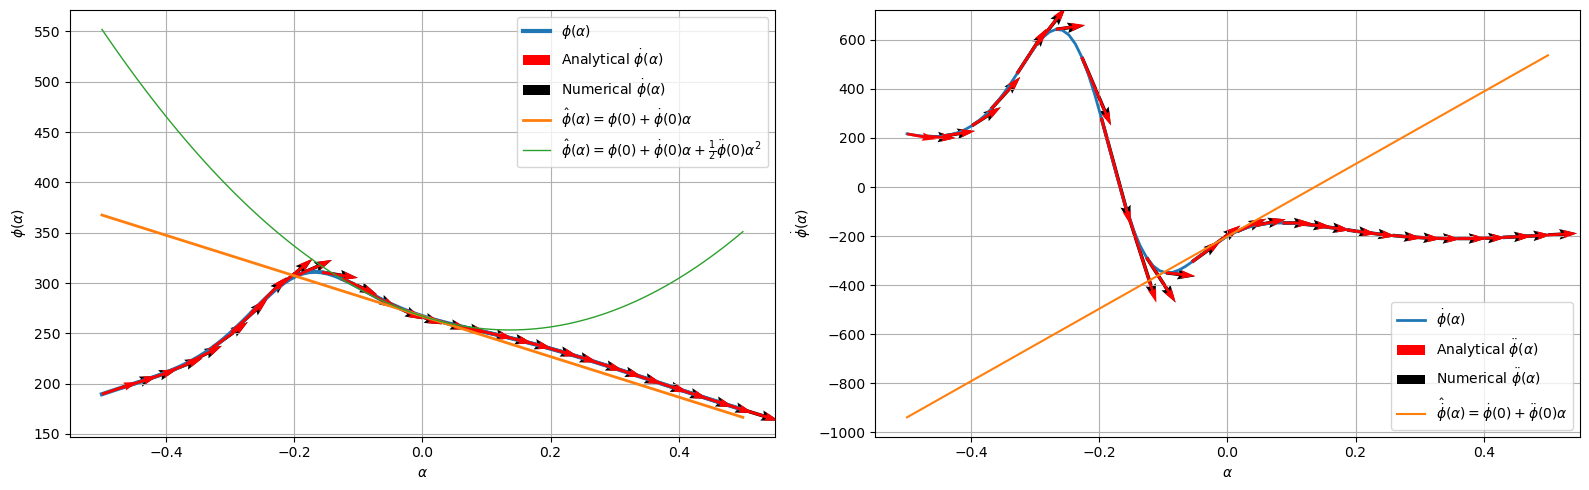

In [117]:
def test_function(p, alpha, x_vec):
    cost = total_differential_equation(p + alpha * x_vec)
    return 1 / 2 * np.linalg.norm(cost)**2

def test_function_grad(p, alpha, x_vec):
    cost = total_differential_equation(p + alpha * x_vec)
    jacobian = total_first_order_partial_derivatives_for_the_differential_equation(p + alpha * x_vec)
    return cost.T @ jacobian @ x_vec

def test_function_hessian(p, alpha, x_vec):
    n = len(x_vec)
    cost = total_differential_equation(p + alpha * x_vec)
    jacobian = total_first_order_partial_derivatives_for_the_differential_equation(p + alpha * x_vec)
    hessian = total_second_order_partial_derivatives_for_the_differential_equation(p + alpha * x_vec).reshape((n * n, n))
    return cost.T @ np.kron(np.eye(n), x_vec).T @ hessian @ x_vec + x_vec.T @ jacobian.T @ jacobian @ x_vec

def test_function_approx_first_order(p, alpha, x_vec):
    return test_function(p, 0, x_vec) + test_function_grad(p, 0, x_vec) * alpha

def test_function_approx_second_order(p, alpha, x_vec):
    return test_function(p, 0, x_vec) + test_function_grad(p, 0, x_vec) * alpha + 1/2 * test_function_hessian(p, 0, x_vec) * alpha**2

def test_function_grad_approx_first_order(p, alpha, x_vec):
    return test_function_grad(p, 0, x_vec) + test_function_hessian(p, 0, x_vec) * alpha

std = 1e0
sample_x_vec = np.random.multivariate_normal(mean=np.zeros(24,), cov=std*np.eye(24)).reshape((24, 1))
p = np.random.multivariate_normal(mean=np.zeros(24,), cov=std*np.eye(24)).reshape((24, 1))

aux = 5e-1
alpha_bounds = np.linspace(-aux, aux, 100)
cost_values = np.array([test_function(p, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
gradient_values = np.array([test_function_grad(p, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
hessian_values = np.array([test_function_hessian(p, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
taylor_series_first_order_expansion_test_function = np.array([test_function_approx_first_order(p, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
taylor_series_second_order_expansion_test_function = np.array([test_function_approx_second_order(p, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
taylor_series_first_order_expansion_test_function_grad = np.array([test_function_grad_approx_first_order(p, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])

# Arrows arrows
num_arrows = 30
arrow_indices = np.linspace(0, len(alpha_bounds) - 1, num_arrows, dtype=int)

def compute_tangent_slope(x, y, idx):
    """Compute the slope of the tangent line at a given index idx."""
    if idx == 0:
        slope = (y[idx + 1] - y[idx]) / (x[idx + 1] - x[idx])
    elif idx == len(x) - 1:
        slope = (y[idx] - y[idx - 1]) / (x[idx] - x[idx - 1])
    else:
        slope = (y[idx + 1] - y[idx - 1]) / (x[idx + 1] - x[idx - 1])

    return slope

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Left plot: Function and gradient arrows
axes[0].plot(alpha_bounds, cost_values, label=r'$\phi(\alpha)$', linewidth=3)
# axes[0].quiver(alpha_bounds[arrow_indices], cost_values[arrow_indices], 
#                np.ones_like(arrow_indices), gradient_values[arrow_indices], 
#                angles='xy', scale_units='xy', color='red', width=0.004, zorder=2, label=r'Analytical $\dot{\phi}(\alpha)$')
# axes[0].quiver(alpha_bounds[arrow_indices][1:], cost_values[arrow_indices][1:],
#                 np.ones_like(arrow_indices[1:]), np.array([compute_tangent_slope(alpha_bounds, cost_values, idx) for idx in arrow_indices])[1:],
#                 angles="xy", scale_units="xy", color="black", width=0.005, label=r'Numerical $\dot{\phi}(\alpha)$')
axes[0].plot(alpha_bounds, taylor_series_first_order_expansion_test_function, label=r'$\hat{\phi}(\alpha) = \phi(0) + \dot{\phi}(0)\alpha$', zorder=3, linewidth=2)
axes[0].plot(alpha_bounds, taylor_series_second_order_expansion_test_function, label=r'$\hat{\phi}(\alpha) = \phi(0) + \dot{\phi}(0)\alpha + \frac{1}{2}\ddot{\phi}(0)\alpha^2$', zorder=3, linewidth=1)
axes[0].set_xlabel(r'$\alpha$')
axes[0].set_ylabel(r'$\phi(\alpha)$')
axes[0].grid()
axes[0].legend()

# Right plot: Gradient and Hessian arrows
axes[1].plot(alpha_bounds, gradient_values, label=r'$\dot{\phi}(\alpha)$', linewidth=2)
# axes[1].quiver(alpha_bounds[arrow_indices], gradient_values[arrow_indices], 
#                np.ones_like(arrow_indices), hessian_values[arrow_indices], 
#                angles='xy', scale_units='xy', color='red', width=0.004, zorder=2, label=r'Analytical $\ddot{\phi}(\alpha)$')
# axes[1].quiver(alpha_bounds[arrow_indices][1:], gradient_values[arrow_indices][1:], 
#                np.ones_like(arrow_indices[1:]), np.array([compute_tangent_slope(alpha_bounds, gradient_values, idx) for idx in arrow_indices])[1:], 
#                angles="xy", scale_units="xy", color="black", width=0.005, label=r'Numerical $\ddot{\phi}(\alpha)$')
axes[1].plot(alpha_bounds, taylor_series_first_order_expansion_test_function_grad, label=r'$\hat{\dot{\phi}}(\alpha) = \dot{\phi}(0) + \ddot{\phi}(0)\alpha$', zorder=3)
axes[1].set_xlabel(r'$\alpha$')
axes[1].set_ylabel(r'$\dot{\phi}(\alpha)$')
axes[1].grid()
axes[1].legend()

plt.tight_layout()
plt.show()

### Derivatives for the solution (single time-step propagation) of the differential equation (acceleration due to gravity) wrt the state vector for one agent

In [123]:
def f(dt, x_old):
    k1 = differential_equation(x_old)
    k2 = differential_equation(x_old + dt / 2 * k1)
    k3 = differential_equation(x_old + dt / 2 * k2)
    k4 = differential_equation(x_old + dt * k3)
    return x_old + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

def Df(dt, x_old):
    n = len(x_old)
    
    k1 = differential_equation(x_old)
    k2 = differential_equation(x_old + dt / 2 * k1)
    k3 = differential_equation(x_old + dt / 2 * k2)

    Dk1 = first_order_partial_derivatives_for_the_differential_equation(x_old)
    Dk2 = first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k1) @ (np.eye(n) + dt / 2 * Dk1)
    Dk3 = first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k2) @ (np.eye(n) + dt / 2 * Dk2)
    Dk4 = first_order_partial_derivatives_for_the_differential_equation(x_old + dt * k3) @ (np.eye(n) + dt * Dk3)
    return np.eye(n) + dt / 6 * (Dk1 + 2 * Dk2 + 2 * Dk3 + Dk4)

def Hf(dt, x_old):
    n = len(x_old)
    
    k1 = differential_equation(x_old)
    k2 = differential_equation(x_old + dt / 2 * k1)
    k3 = differential_equation(x_old + dt / 2 * k2)

    Dk1 = first_order_partial_derivatives_for_the_differential_equation(x_old)
    Dk2 = first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k1) @ (np.eye(n) + dt / 2 * Dk1)
    Dk3 = first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k2) @ (np.eye(n) + dt / 2 * Dk2)
    
    Hk1 = second_order_partial_derivatives_for_the_differential_equation(x_old).reshape((n * n, n))
    Hk2 = np.kron(np.eye(n), np.eye(n) + dt / 2 * Dk1).T @ second_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k1).reshape((n * n, n)) @ (np.eye(n) + dt / 2 * Dk1) + np.kron(first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k1), np.eye(n)) @ (dt / 2 * Hk1)
    Hk3 = np.kron(np.eye(n), np.eye(n) + dt / 2 * Dk2).T @ second_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k2).reshape((n * n, n)) @ (np.eye(n) + dt / 2 * Dk2) + np.kron(first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k2), np.eye(n)) @ (dt / 2 * Hk2)
    Hk4 = np.kron(np.eye(n), np.eye(n) + dt * Dk3).T @ second_order_partial_derivatives_for_the_differential_equation(x_old + dt * k3).reshape((n * n, n)) @ (np.eye(n) + dt * Dk3) + np.kron(first_order_partial_derivatives_for_the_differential_equation(x_old + dt * k3), np.eye(n)) @ (dt * Hk3)
    return dt / 6 * (Hk1 + 2 * Hk2 + 2 * Hk3 + Hk4)

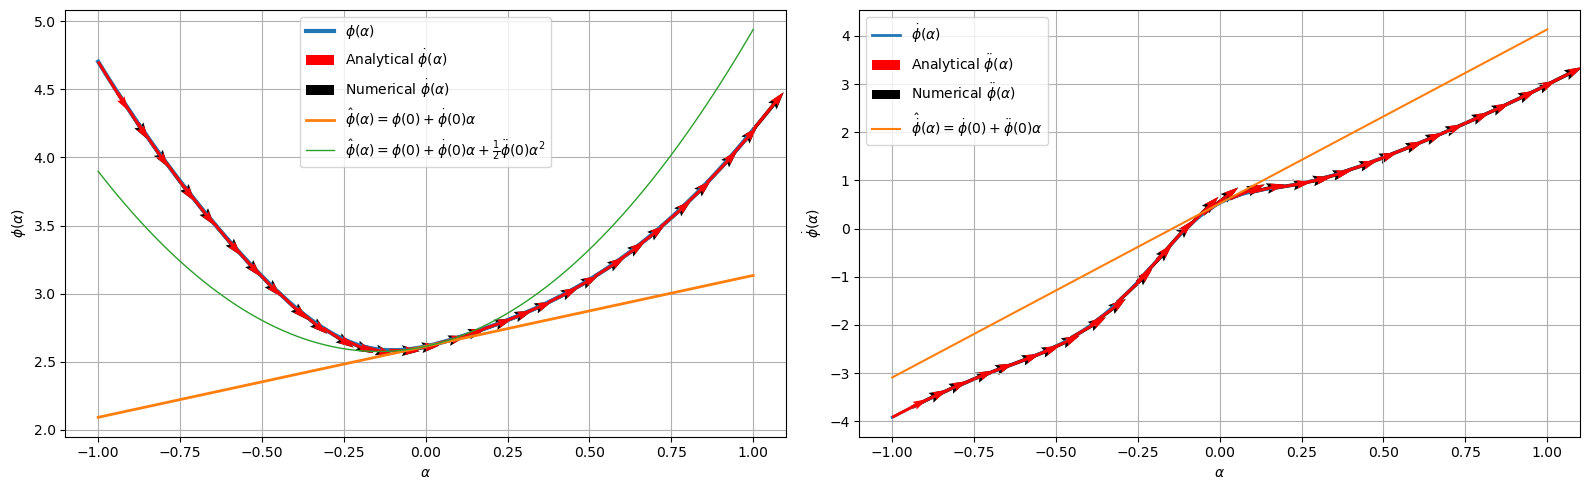

In [131]:
def test_function(dt, p, alpha, x_vec):
    cost = f(dt, p + alpha * x_vec)
    return 1 / 2 * np.linalg.norm(cost)**2

def test_function_grad(dt, p, alpha, x_vec):
    cost = f(dt, p + alpha * x_vec)
    jacobian = Df(dt, p + alpha * x_vec)
    return cost.T @ jacobian @ x_vec

def test_function_hessian(dt, p, alpha, x_vec):
    n = len(x_vec)
    cost = f(dt, p + alpha * x_vec)
    jacobian = Df(dt, p + alpha * x_vec)
    hessian = Hf(dt, p + alpha * x_vec)
    return cost.T @ np.kron(np.eye(n), x_vec).T @ hessian @ x_vec + x_vec.T @ jacobian.T @ jacobian @ x_vec

def test_function_approx_first_order(dt, p, alpha, x_vec):
    return test_function(dt, p, 0, x_vec) + test_function_grad(dt, p, 0, x_vec) * alpha

def test_function_approx_second_order(dt, p, alpha, x_vec):
    return test_function(dt, p, 0, x_vec) + test_function_grad(dt, p, 0, x_vec) * alpha + 1/2 * test_function_hessian(dt, p, 0, x_vec) * alpha**2

def test_function_grad_approx_first_order(dt, p, alpha, x_vec):
    return test_function_grad(dt, p, 0, x_vec) + test_function_hessian(dt, p, 0, x_vec) * alpha

std = 1e0
sample_x_vec = np.random.multivariate_normal(mean=np.zeros(6,), cov=std*np.eye(6)).reshape((6, 1))
p = np.random.multivariate_normal(mean=np.zeros(6,), cov=std*np.eye(6)).reshape((6, 1))

dt = 1.0
aux = 5e-1
alpha_bounds = np.linspace(-aux, aux, 100)
cost_values = np.array([test_function(dt, p, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
gradient_values = np.array([test_function_grad(dt, p, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
hessian_values = np.array([test_function_hessian(dt, p, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
taylor_series_first_order_expansion_test_function = np.array([test_function_approx_first_order(dt, p, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
taylor_series_second_order_expansion_test_function = np.array([test_function_approx_second_order(dt, p, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
taylor_series_first_order_expansion_test_function_grad = np.array([test_function_grad_approx_first_order(dt, p, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])

# Arrows arrows
num_arrows = 30
arrow_indices = np.linspace(0, len(alpha_bounds) - 1, num_arrows, dtype=int)

def compute_tangent_slope(x, y, idx):
    """Compute the slope of the tangent line at a given index idx."""
    if idx == 0:
        slope = (y[idx + 1] - y[idx]) / (x[idx + 1] - x[idx])
    elif idx == len(x) - 1:
        slope = (y[idx] - y[idx - 1]) / (x[idx] - x[idx - 1])
    else:
        slope = (y[idx + 1] - y[idx - 1]) / (x[idx + 1] - x[idx - 1])

    return slope

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Left plot: Function and gradient arrows
axes[0].plot(alpha_bounds, cost_values, label=r'$\phi(\alpha)$', linewidth=3)
axes[0].quiver(alpha_bounds[arrow_indices], cost_values[arrow_indices], 
               np.ones_like(arrow_indices), gradient_values[arrow_indices], 
               angles='xy', scale_units='xy', color='red', width=0.004, zorder=2, label=r'Analytical $\dot{\phi}(\alpha)$')
axes[0].quiver(alpha_bounds[arrow_indices][1:], cost_values[arrow_indices][1:],
                np.ones_like(arrow_indices[1:]), np.array([compute_tangent_slope(alpha_bounds, cost_values, idx) for idx in arrow_indices])[1:],
                angles="xy", scale_units="xy", color="black", width=0.005, label=r'Numerical $\dot{\phi}(\alpha)$')
axes[0].plot(alpha_bounds, taylor_series_first_order_expansion_test_function, label=r'$\hat{\phi}(\alpha) = \phi(0) + \dot{\phi}(0)\alpha$', zorder=3, linewidth=2)
axes[0].plot(alpha_bounds, taylor_series_second_order_expansion_test_function, label=r'$\hat{\phi}(\alpha) = \phi(0) + \dot{\phi}(0)\alpha + \frac{1}{2}\ddot{\phi}(0)\alpha^2$', zorder=3, linewidth=1)
axes[0].set_xlabel(r'$\alpha$')
axes[0].set_ylabel(r'$\phi(\alpha)$')
axes[0].grid()
axes[0].legend()

# Right plot: Gradient and Hessian arrows
axes[1].plot(alpha_bounds, gradient_values, label=r'$\dot{\phi}(\alpha)$', linewidth=2)
axes[1].quiver(alpha_bounds[arrow_indices], gradient_values[arrow_indices], 
               np.ones_like(arrow_indices), hessian_values[arrow_indices], 
               angles='xy', scale_units='xy', color='red', width=0.004, zorder=2, label=r'Analytical $\ddot{\phi}(\alpha)$')
axes[1].quiver(alpha_bounds[arrow_indices][1:], gradient_values[arrow_indices][1:], 
               np.ones_like(arrow_indices[1:]), np.array([compute_tangent_slope(alpha_bounds, gradient_values, idx) for idx in arrow_indices])[1:], 
               angles="xy", scale_units="xy", color="black", width=0.005, label=r'Numerical $\ddot{\phi}(\alpha)$')
axes[1].plot(alpha_bounds, taylor_series_first_order_expansion_test_function_grad, label=r'$\hat{\dot{\phi}}(\alpha) = \dot{\phi}(0) + \ddot{\phi}(0)\alpha$', zorder=3)
axes[1].set_xlabel(r'$\alpha$')
axes[1].set_ylabel(r'$\dot{\phi}(\alpha)$')
axes[1].grid()
axes[1].legend()

plt.tight_layout()
plt.show()

### Derivatives for the solution (tau time-steps propagation) of the differential equation (acceleration due to gravity) wrt the state vector for one agent

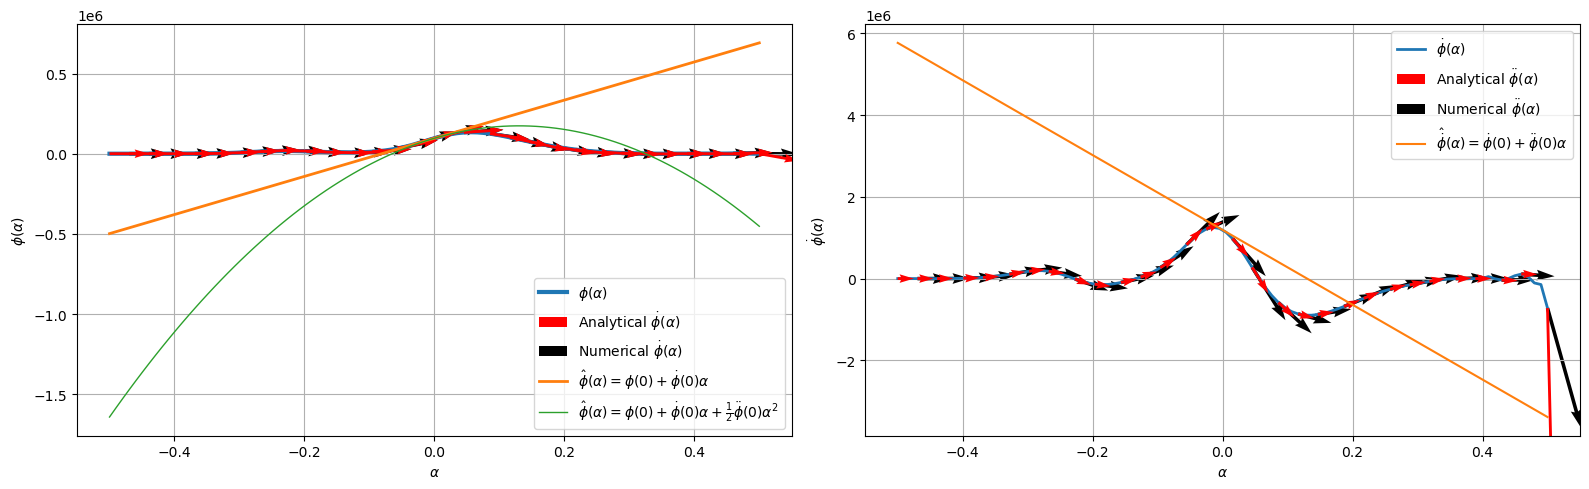

In [139]:
def test_function(tau, dt, p, alpha, x_vec):
    x_vec_new = p + alpha * x_vec
    for _ in range(tau):
        x_vec_new = f(dt, x_vec_new)
    cost = x_vec_new
    return 1 / 2 * np.linalg.norm(cost)**2

def test_function_grad(tau, dt, p, alpha, x_vec):
    n = len(x_vec)
    x_vec_new = p + alpha * x_vec
    STM = np.eye(n)
    for _ in range(tau):
        STM = Df(dt, x_vec_new) @ STM
        x_vec_new = f(dt, x_vec_new)
    cost = x_vec_new
    jacobian = STM
    return cost.T @ jacobian @ x_vec

def test_function_hessian(tau,dt, p, alpha, x_vec):
    n = len(x_vec)
    x_vec_new = p + alpha * x_vec
    STM = np.eye(n)
    DSTM = np.zeros((n * n, n))
    for _ in range(tau):
        DSTM = np.kron(np.eye(n), STM).T @ Hf(dt, x_vec_new) @ STM + np.kron(Df(dt, x_vec_new), np.eye(n)) @ DSTM
        STM = Df(dt, x_vec_new) @ STM
        x_vec_new = f(dt, x_vec_new)
    cost = x_vec_new
    jacobian = STM
    hessian = DSTM
    return cost.T @ np.kron(np.eye(n), x_vec).T @ hessian @ x_vec + x_vec.T @ jacobian.T @ jacobian @ x_vec

def test_function_approx_first_order(tau, dt, p, alpha, x_vec):
    return test_function(tau, dt, p, 0, x_vec) + test_function_grad(tau, dt, p, 0, x_vec) * alpha

def test_function_approx_second_order(tau, dt, p, alpha, x_vec):
    return test_function(tau, dt, p, 0, x_vec) + test_function_grad(tau, dt, p, 0, x_vec) * alpha + 1/2 * test_function_hessian(tau, dt, p, 0, x_vec) * alpha**2

def test_function_grad_approx_first_order(tau, dt, p, alpha, x_vec):
    return test_function_grad(tau, dt, p, 0, x_vec) + test_function_hessian(tau, dt, p, 0, x_vec) * alpha

std = 1e0
sample_x_vec = np.random.multivariate_normal(mean=np.zeros(6,), cov=std*np.eye(6)).reshape((6, 1))
p = np.random.multivariate_normal(mean=np.zeros(6,), cov=std*np.eye(6)).reshape((6, 1))

tau = 4
dt = 1.0
aux = 5e-1
alpha_bounds = np.linspace(-aux, aux, 100)
cost_values = np.array([test_function(tau, dt, p, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
gradient_values = np.array([test_function_grad(tau, dt, p, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
hessian_values = np.array([test_function_hessian(tau, dt, p, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
taylor_series_first_order_expansion_test_function = np.array([test_function_approx_first_order(tau, dt, p, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
taylor_series_second_order_expansion_test_function = np.array([test_function_approx_second_order(tau, dt, p, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
taylor_series_first_order_expansion_test_function_grad = np.array([test_function_grad_approx_first_order(tau, dt, p, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])

# Arrows arrows
num_arrows = 30
arrow_indices = np.linspace(0, len(alpha_bounds) - 1, num_arrows, dtype=int)

def compute_tangent_slope(x, y, idx):
    """Compute the slope of the tangent line at a given index idx."""
    if idx == 0:
        slope = (y[idx + 1] - y[idx]) / (x[idx + 1] - x[idx])
    elif idx == len(x) - 1:
        slope = (y[idx] - y[idx - 1]) / (x[idx] - x[idx - 1])
    else:
        slope = (y[idx + 1] - y[idx - 1]) / (x[idx + 1] - x[idx - 1])

    return slope

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Left plot: Function and gradient arrows
axes[0].plot(alpha_bounds, cost_values, label=r'$\phi(\alpha)$', linewidth=3)
axes[0].quiver(alpha_bounds[arrow_indices], cost_values[arrow_indices], 
               np.ones_like(arrow_indices), gradient_values[arrow_indices], 
               angles='xy', scale_units='xy', color='red', width=0.004, zorder=2, label=r'Analytical $\dot{\phi}(\alpha)$')
axes[0].quiver(alpha_bounds[arrow_indices][1:], cost_values[arrow_indices][1:],
                np.ones_like(arrow_indices[1:]), np.array([compute_tangent_slope(alpha_bounds, cost_values, idx) for idx in arrow_indices])[1:],
                angles="xy", scale_units="xy", color="black", width=0.005, label=r'Numerical $\dot{\phi}(\alpha)$')
axes[0].plot(alpha_bounds, taylor_series_first_order_expansion_test_function, label=r'$\hat{\phi}(\alpha) = \phi(0) + \dot{\phi}(0)\alpha$', zorder=3, linewidth=2)
axes[0].plot(alpha_bounds, taylor_series_second_order_expansion_test_function, label=r'$\hat{\phi}(\alpha) = \phi(0) + \dot{\phi}(0)\alpha + \frac{1}{2}\ddot{\phi}(0)\alpha^2$', zorder=3, linewidth=1)
axes[0].set_xlabel(r'$\alpha$')
axes[0].set_ylabel(r'$\phi(\alpha)$')
axes[0].grid()
axes[0].legend()

# Right plot: Gradient and Hessian arrows
axes[1].plot(alpha_bounds, gradient_values, label=r'$\dot{\phi}(\alpha)$', linewidth=2)
axes[1].quiver(alpha_bounds[arrow_indices], gradient_values[arrow_indices], 
               np.ones_like(arrow_indices), hessian_values[arrow_indices], 
               angles='xy', scale_units='xy', color='red', width=0.004, zorder=2, label=r'Analytical $\ddot{\phi}(\alpha)$')
axes[1].quiver(alpha_bounds[arrow_indices][1:], gradient_values[arrow_indices][1:], 
               np.ones_like(arrow_indices[1:]), np.array([compute_tangent_slope(alpha_bounds, gradient_values, idx) for idx in arrow_indices])[1:], 
               angles="xy", scale_units="xy", color="black", width=0.005, label=r'Numerical $\ddot{\phi}(\alpha)$')
axes[1].plot(alpha_bounds, taylor_series_first_order_expansion_test_function_grad, label=r'$\hat{\dot{\phi}}(\alpha) = \dot{\phi}(0) + \ddot{\phi}(0)\alpha$', zorder=3)
axes[1].set_xlabel(r'$\alpha$')
axes[1].set_ylabel(r'$\dot{\phi}(\alpha)$')
axes[1].grid()
axes[1].legend()

plt.tight_layout()
plt.show()

### Derivatives for the solution (single time-step propagation) of the differential equation (acceleration due to gravity) wrt the total state vector

In [140]:
def f(dt, x_old):
    k1 = total_differential_equation(x_old)
    k2 = total_differential_equation(x_old + dt / 2 * k1)
    k3 = total_differential_equation(x_old + dt / 2 * k2)
    k4 = total_differential_equation(x_old + dt * k3)
    return x_old + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

def Df(dt, x_old):
    n = len(x_old)
    
    k1 = total_differential_equation(x_old)
    k2 = total_differential_equation(x_old + dt / 2 * k1)
    k3 = total_differential_equation(x_old + dt / 2 * k2)

    Dk1 = total_first_order_partial_derivatives_for_the_differential_equation(x_old)
    Dk2 = total_first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k1) @ (np.eye(n) + dt / 2 * Dk1)
    Dk3 = total_first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k2) @ (np.eye(n) + dt / 2 * Dk2)
    Dk4 = total_first_order_partial_derivatives_for_the_differential_equation(x_old + dt * k3) @ (np.eye(n) + dt * Dk3)
    return np.eye(n) + dt / 6 * (Dk1 + 2 * Dk2 + 2 * Dk3 + Dk4)

def Hf(dt, x_old):
    n = len(x_old)
    
    k1 = total_differential_equation(x_old)
    k2 = total_differential_equation(x_old + dt / 2 * k1)
    k3 = total_differential_equation(x_old + dt / 2 * k2)

    Dk1 = total_first_order_partial_derivatives_for_the_differential_equation(x_old)
    Dk2 = total_first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k1) @ (np.eye(n) + dt / 2 * Dk1)
    Dk3 = total_first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k2) @ (np.eye(n) + dt / 2 * Dk2)

    Hk1 = total_second_order_partial_derivatives_for_the_differential_equation(x_old).reshape((n * n, n))
    Hk2 = np.kron(np.eye(n), np.eye(n) + dt / 2 * Dk1).T @ total_second_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k1).reshape((n * n, n)) @ (np.eye(n) + dt / 2 * Dk1) + np.kron(total_first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k1), np.eye(n)) @ (dt / 2 * Hk1)
    Hk3 = np.kron(np.eye(n), np.eye(n) + dt / 2 * Dk2).T @ total_second_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k2).reshape((n * n, n)) @ (np.eye(n) + dt / 2 * Dk2) + np.kron(total_first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k2), np.eye(n)) @ (dt / 2 * Hk2)
    Hk4 = np.kron(np.eye(n), np.eye(n) + dt * Dk3).T @ total_second_order_partial_derivatives_for_the_differential_equation(x_old + dt * k3).reshape((n * n, n)) @ (np.eye(n) + dt * Dk3) + np.kron(total_first_order_partial_derivatives_for_the_differential_equation(x_old + dt * k3), np.eye(n)) @ (dt * Hk3)
    return dt / 6 * (Hk1 + 2 * Hk2 + 2 * Hk3 + Hk4)

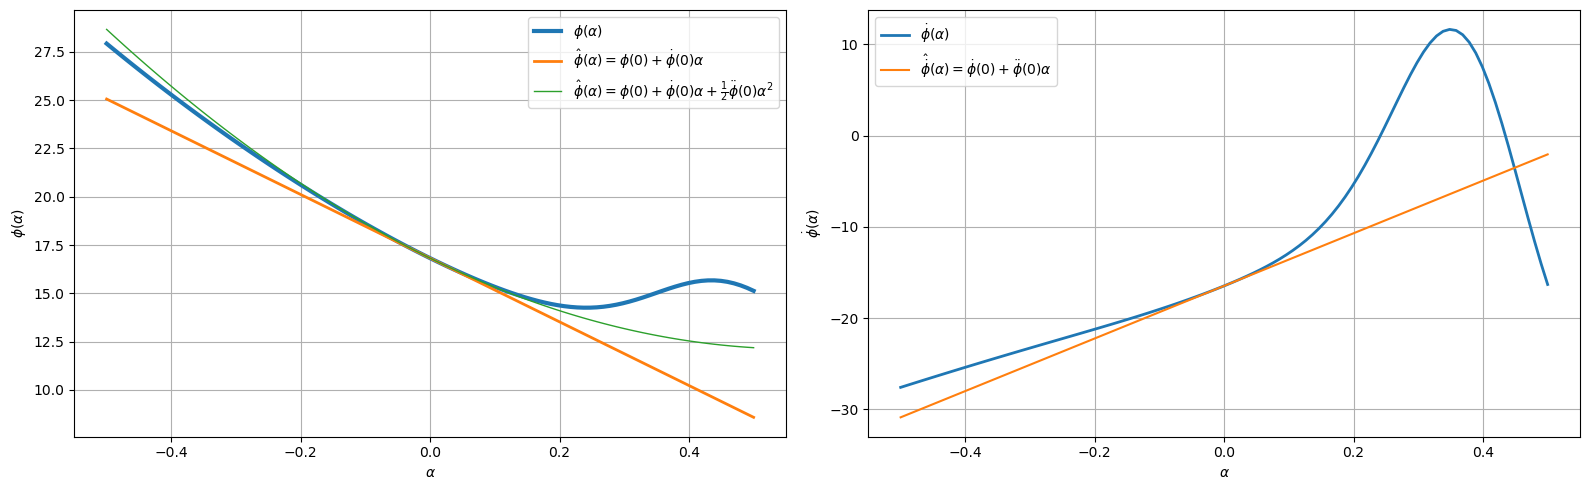

In [141]:
def test_function(dt, p, alpha, x_vec):
    cost = f(dt, p + alpha * x_vec)
    return 1 / 2 * np.linalg.norm(cost)**2

def test_function_grad(dt, p, alpha, x_vec):
    cost = f(dt, p + alpha * x_vec)
    jacobian = Df(dt, p + alpha * x_vec)
    return cost.T @ jacobian @ x_vec

def test_function_hessian(dt, p, alpha, x_vec):
    n = len(x_vec)
    cost = f(dt, p + alpha * x_vec)
    jacobian = Df(dt, p + alpha * x_vec)
    hessian = Hf(dt, p + alpha * x_vec)
    return cost.T @ np.kron(np.eye(n), x_vec).T @ hessian @ x_vec + x_vec.T @ jacobian.T @ jacobian @ x_vec

def test_function_approx_first_order(dt, p, alpha, x_vec):
    return test_function(dt, p, 0, x_vec) + test_function_grad(dt, p, 0, x_vec) * alpha

def test_function_approx_second_order(dt, p, alpha, x_vec):
    return test_function(dt, p, 0, x_vec) + test_function_grad(dt, p, 0, x_vec) * alpha + 1/2 * test_function_hessian(dt, p, 0, x_vec) * alpha**2

def test_function_grad_approx_first_order(dt, p, alpha, x_vec):
    return test_function_grad(dt, p, 0, x_vec) + test_function_hessian(dt, p, 0, x_vec) * alpha

std = 1e0
sample_x_vec = np.random.multivariate_normal(mean=np.zeros(24,), cov=std*np.eye(24)).reshape((24, 1))
p = np.random.multivariate_normal(mean=np.zeros(24,), cov=std*np.eye(24)).reshape((24, 1))

dt = 1.0
aux = 5e-1
alpha_bounds = np.linspace(-aux, aux, 100)
cost_values = np.array([test_function(dt, p, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
gradient_values = np.array([test_function_grad(dt, p, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
hessian_values = np.array([test_function_hessian(dt, p, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
taylor_series_first_order_expansion_test_function = np.array([test_function_approx_first_order(dt, p, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
taylor_series_second_order_expansion_test_function = np.array([test_function_approx_second_order(dt, p, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
taylor_series_first_order_expansion_test_function_grad = np.array([test_function_grad_approx_first_order(dt, p, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])

# Arrows arrows
num_arrows = 30
arrow_indices = np.linspace(0, len(alpha_bounds) - 1, num_arrows, dtype=int)

def compute_tangent_slope(x, y, idx):
    """Compute the slope of the tangent line at a given index idx."""
    if idx == 0:
        slope = (y[idx + 1] - y[idx]) / (x[idx + 1] - x[idx])
    elif idx == len(x) - 1:
        slope = (y[idx] - y[idx - 1]) / (x[idx] - x[idx - 1])
    else:
        slope = (y[idx + 1] - y[idx - 1]) / (x[idx + 1] - x[idx - 1])

    return slope

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Left plot: Function and gradient arrows
axes[0].plot(alpha_bounds, cost_values, label=r'$\phi(\alpha)$', linewidth=3)
# axes[0].quiver(alpha_bounds[arrow_indices], cost_values[arrow_indices], 
#                np.ones_like(arrow_indices), gradient_values[arrow_indices], 
#                angles='xy', scale_units='xy', color='red', width=0.004, zorder=2, label=r'Analytical $\dot{\phi}(\alpha)$')
# axes[0].quiver(alpha_bounds[arrow_indices][1:], cost_values[arrow_indices][1:],
#                 np.ones_like(arrow_indices[1:]), np.array([compute_tangent_slope(alpha_bounds, cost_values, idx) for idx in arrow_indices])[1:],
#                 angles="xy", scale_units="xy", color="black", width=0.005, label=r'Numerical $\dot{\phi}(\alpha)$')
axes[0].plot(alpha_bounds, taylor_series_first_order_expansion_test_function, label=r'$\hat{\phi}(\alpha) = \phi(0) + \dot{\phi}(0)\alpha$', zorder=3, linewidth=2)
axes[0].plot(alpha_bounds, taylor_series_second_order_expansion_test_function, label=r'$\hat{\phi}(\alpha) = \phi(0) + \dot{\phi}(0)\alpha + \frac{1}{2}\ddot{\phi}(0)\alpha^2$', zorder=3, linewidth=1)
axes[0].set_xlabel(r'$\alpha$')
axes[0].set_ylabel(r'$\phi(\alpha)$')
axes[0].grid()
axes[0].legend()

# Right plot: Gradient and Hessian arrows
axes[1].plot(alpha_bounds, gradient_values, label=r'$\dot{\phi}(\alpha)$', linewidth=2)
# axes[1].quiver(alpha_bounds[arrow_indices], gradient_values[arrow_indices], 
#                np.ones_like(arrow_indices), hessian_values[arrow_indices], 
#                angles='xy', scale_units='xy', color='red', width=0.004, zorder=2, label=r'Analytical $\ddot{\phi}(\alpha)$')
# axes[1].quiver(alpha_bounds[arrow_indices][1:], gradient_values[arrow_indices][1:], 
#                np.ones_like(arrow_indices[1:]), np.array([compute_tangent_slope(alpha_bounds, gradient_values, idx) for idx in arrow_indices])[1:], 
#                angles="xy", scale_units="xy", color="black", width=0.005, label=r'Numerical $\ddot{\phi}(\alpha)$')
axes[1].plot(alpha_bounds, taylor_series_first_order_expansion_test_function_grad, label=r'$\hat{\dot{\phi}}(\alpha) = \dot{\phi}(0) + \ddot{\phi}(0)\alpha$', zorder=3)
axes[1].set_xlabel(r'$\alpha$')
axes[1].set_ylabel(r'$\dot{\phi}(\alpha)$')
axes[1].grid()
axes[1].legend()

plt.tight_layout()
plt.show()

### Derivatives for the solution (tau time-steps propagation) of the differential equation (acceleration due to gravity) wrt the total state vector

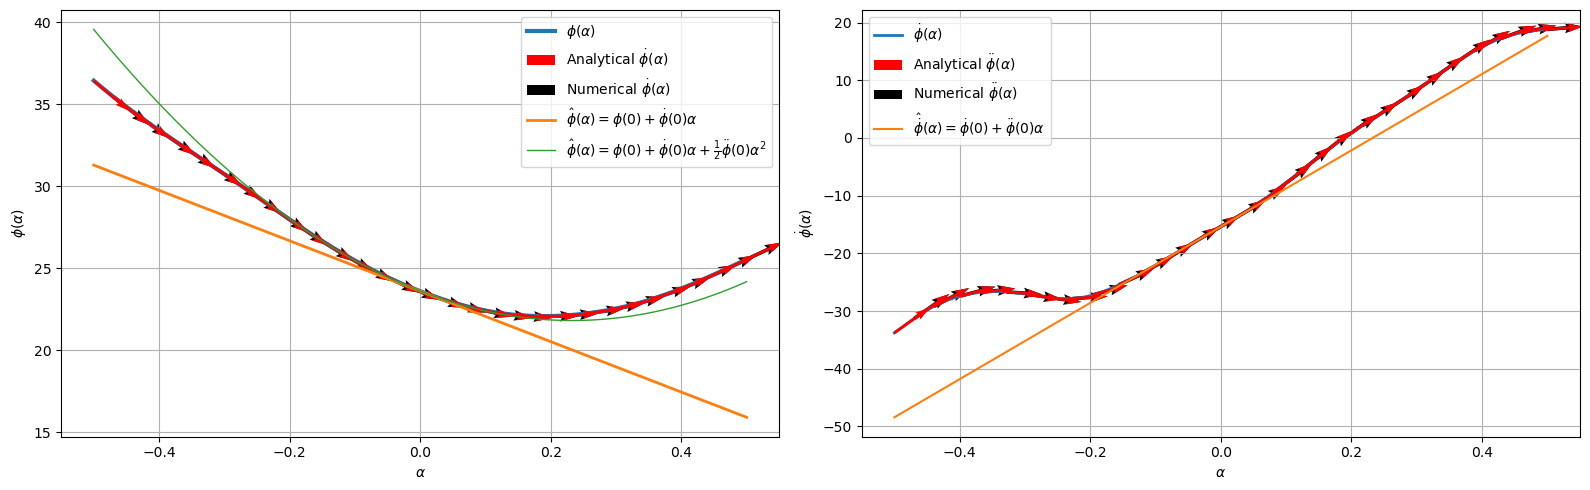

In [142]:
def test_function(tau, dt, p, alpha, x_vec):
    x_vec_new = p + alpha * x_vec
    for _ in range(tau):
        x_vec_new = f(dt, x_vec_new)
    cost = x_vec_new
    return 1 / 2 * np.linalg.norm(cost)**2

def test_function_grad(tau, dt, p, alpha, x_vec):
    n = len(x_vec)
    x_vec_new = p + alpha * x_vec
    STM = np.eye(n)
    for _ in range(tau):
        STM = Df(dt, x_vec_new) @ STM
        x_vec_new = f(dt, x_vec_new)
    cost = x_vec_new
    jacobian = STM
    return cost.T @ jacobian @ x_vec

def test_function_hessian(tau,dt, p, alpha, x_vec):
    n = len(x_vec)
    x_vec_new = p + alpha * x_vec
    STM = np.eye(n)
    DSTM = np.zeros((n * n, n))
    for _ in range(tau):
        DSTM = np.kron(np.eye(n), STM).T @ Hf(dt, x_vec_new) @ STM + np.kron(Df(dt, x_vec_new), np.eye(n)) @ DSTM
        STM = Df(dt, x_vec_new) @ STM
        x_vec_new = f(dt, x_vec_new)
    cost = x_vec_new
    jacobian = STM
    hessian = DSTM
    return cost.T @ np.kron(np.eye(n), x_vec).T @ hessian @ x_vec + x_vec.T @ jacobian.T @ jacobian @ x_vec

def test_function_approx_first_order(tau, dt, p, alpha, x_vec):
    return test_function(tau, dt, p, 0, x_vec) + test_function_grad(tau, dt, p, 0, x_vec) * alpha

def test_function_approx_second_order(tau, dt, p, alpha, x_vec):
    return test_function(tau, dt, p, 0, x_vec) + test_function_grad(tau, dt, p, 0, x_vec) * alpha + 1/2 * test_function_hessian(tau, dt, p, 0, x_vec) * alpha**2

def test_function_grad_approx_first_order(tau, dt, p, alpha, x_vec):
    return test_function_grad(tau, dt, p, 0, x_vec) + test_function_hessian(tau, dt, p, 0, x_vec) * alpha

std = 1e0
sample_x_vec = np.random.multivariate_normal(mean=np.zeros(24,), cov=std*np.eye(24)).reshape((24, 1))
p = np.random.multivariate_normal(mean=np.zeros(24,), cov=std*np.eye(24)).reshape((24, 1))

tau = 2
dt = 1.0
aux = 5e-1
alpha_bounds = np.linspace(-aux, aux, 100)
cost_values = np.array([test_function(tau, dt, p, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
gradient_values = np.array([test_function_grad(tau, dt, p, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
hessian_values = np.array([test_function_hessian(tau, dt, p, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
taylor_series_first_order_expansion_test_function = np.array([test_function_approx_first_order(tau, dt, p, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
taylor_series_second_order_expansion_test_function = np.array([test_function_approx_second_order(tau, dt, p, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
taylor_series_first_order_expansion_test_function_grad = np.array([test_function_grad_approx_first_order(tau, dt, p, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])

# Arrows arrows
num_arrows = 30
arrow_indices = np.linspace(0, len(alpha_bounds) - 1, num_arrows, dtype=int)

def compute_tangent_slope(x, y, idx):
    """Compute the slope of the tangent line at a given index idx."""
    if idx == 0:
        slope = (y[idx + 1] - y[idx]) / (x[idx + 1] - x[idx])
    elif idx == len(x) - 1:
        slope = (y[idx] - y[idx - 1]) / (x[idx] - x[idx - 1])
    else:
        slope = (y[idx + 1] - y[idx - 1]) / (x[idx + 1] - x[idx - 1])

    return slope

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Left plot: Function and gradient arrows
axes[0].plot(alpha_bounds, cost_values, label=r'$\phi(\alpha)$', linewidth=3)
axes[0].quiver(alpha_bounds[arrow_indices], cost_values[arrow_indices], 
               np.ones_like(arrow_indices), gradient_values[arrow_indices], 
               angles='xy', scale_units='xy', color='red', width=0.004, zorder=2, label=r'Analytical $\dot{\phi}(\alpha)$')
axes[0].quiver(alpha_bounds[arrow_indices][1:], cost_values[arrow_indices][1:],
                np.ones_like(arrow_indices[1:]), np.array([compute_tangent_slope(alpha_bounds, cost_values, idx) for idx in arrow_indices])[1:],
                angles="xy", scale_units="xy", color="black", width=0.005, label=r'Numerical $\dot{\phi}(\alpha)$')
axes[0].plot(alpha_bounds, taylor_series_first_order_expansion_test_function, label=r'$\hat{\phi}(\alpha) = \phi(0) + \dot{\phi}(0)\alpha$', zorder=3, linewidth=2)
axes[0].plot(alpha_bounds, taylor_series_second_order_expansion_test_function, label=r'$\hat{\phi}(\alpha) = \phi(0) + \dot{\phi}(0)\alpha + \frac{1}{2}\ddot{\phi}(0)\alpha^2$', zorder=3, linewidth=1)
axes[0].set_xlabel(r'$\alpha$')
axes[0].set_ylabel(r'$\phi(\alpha)$')
axes[0].grid()
axes[0].legend()

# Right plot: Gradient and Hessian arrows
axes[1].plot(alpha_bounds, gradient_values, label=r'$\dot{\phi}(\alpha)$', linewidth=2)
axes[1].quiver(alpha_bounds[arrow_indices], gradient_values[arrow_indices], 
               np.ones_like(arrow_indices), hessian_values[arrow_indices], 
               angles='xy', scale_units='xy', color='red', width=0.004, zorder=2, label=r'Analytical $\ddot{\phi}(\alpha)$')
axes[1].quiver(alpha_bounds[arrow_indices][1:], gradient_values[arrow_indices][1:], 
               np.ones_like(arrow_indices[1:]), np.array([compute_tangent_slope(alpha_bounds, gradient_values, idx) for idx in arrow_indices])[1:], 
               angles="xy", scale_units="xy", color="black", width=0.005, label=r'Numerical $\ddot{\phi}(\alpha)$')
axes[1].plot(alpha_bounds, taylor_series_first_order_expansion_test_function_grad, label=r'$\hat{\dot{\phi}}(\alpha) = \dot{\phi}(0) + \ddot{\phi}(0)\alpha$', zorder=3)
axes[1].set_xlabel(r'$\alpha$')
axes[1].set_ylabel(r'$\dot{\phi}(\alpha)$')
axes[1].grid()
axes[1].legend()

plt.tight_layout()
plt.show()